In [1]:
import numpy as np
import cv2
import glob
import pickle
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog

from scipy.ndimage.measurements import label

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

from moviepy.editor import VideoFileClip

%matplotlib inline

### Useful functions

In [2]:
# Functions from https://classroom.udacity.com/nanodegrees/nd013
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Resign from bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


### Load data

In [3]:
vehicle_images = glob.glob('train_images/vehicles/**/*.png')
non_vehicle_images = glob.glob('train_images/non-vehicles/**/*.png')
print('Number of vehicle images:', len(vehicle_images), 'Number of non vehicle images:', len(non_vehicle_images))

Number of vehicle images: 8792 Number of non vehicle images: 8968


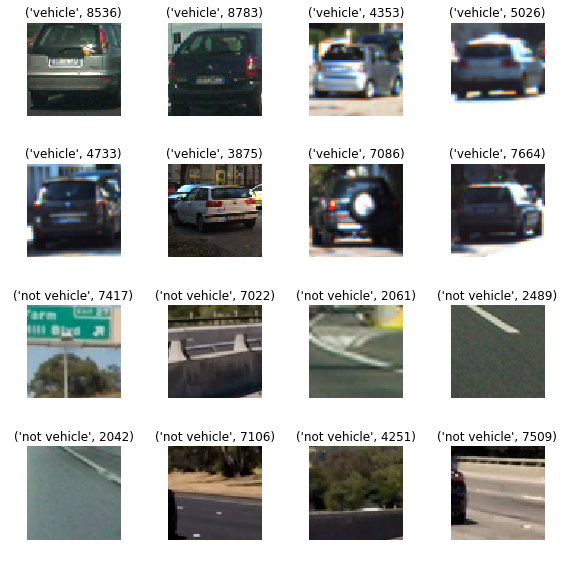

In [4]:
# Show example data
rows = 4
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(8, 8))
plt.tight_layout()
for i in range (rows):
    for j in range (cols):
        if i < rows/2:
            index = np.random.randint(0, len(vehicle_images))
            image = cv2.imread(vehicle_images[index]).squeeze()
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            label = 'vehicle', index
        else:
            index = np.random.randint(0, len(non_vehicle_images))
            image = cv2.imread(non_vehicle_images[index]).squeeze()
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            label = 'not vehicle', index
        axs[i,j].imshow(image)
        axs[i,j].axis('off')
        axs[i,j].set_title(label)

### Histogram of Oriented Gradients (HOG)

(-0.5, 63.5, 63.5, -0.5)

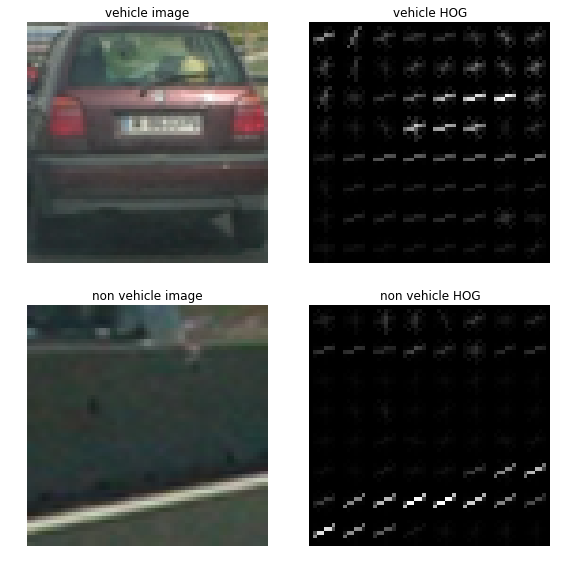

In [5]:
vehicle_image = mpimg.imread(vehicle_images[0])
_, vehicle_hog = get_hog_features(vehicle_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
non_vehicle_image = mpimg.imread(non_vehicle_images[2])
_, non_vehicle_hog = get_hog_features(non_vehicle_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.tight_layout()

axs[0,0].imshow(vehicle_image)
axs[0,0].set_title('vehicle image')
axs[0,0].axis('off')
axs[0,1].imshow(vehicle_hog, cmap='gray')
axs[0,1].set_title('vehicle HOG')
axs[0,1].axis('off')

axs[1,0].imshow(non_vehicle_image)
axs[1,0].set_title('non vehicle image')
axs[1,0].axis('off')
axs[1,1].imshow(non_vehicle_hog, cmap='gray')
axs[1,1].set_title('non vehicle HOG')
axs[1,1].axis('off')

In [6]:
### Parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Get features
t=time.time()
vehicle_features = extract_features(vehicle_images, color_space=colorspace, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel)

non_vehicle_features = extract_features(non_vehicle_images, color_space=colorspace, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

print(len(vehicle_features))

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


96.96 Seconds to extract HOG features...
8792
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


### Train a classifier

In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9806
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.0036 Seconds to predict 10 labels with SVC


### Sliding Window Search

In [8]:
# Functions from https://classroom.udacity.com/nanodegrees/nd013

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, hog_channel, colorspace):
    
    bboxes = []
    all_bboxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if colorspace != 'RGB':
        if colorspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif colorspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif colorspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif colorspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif colorspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = draw_img
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    # Modify udacity code, at the end was pix_per_cell)-1, chande to +1
    # now finds features if is searching in only one row
    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_size is not None:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            if hist_bins is not None:
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            if X_scaler is not None:
                if spatial_size is not None and hist_bins is not None:
                    test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)
                elif spatial_size is not None:
                    test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)
                elif hist_bins is not None:
                    test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)
                else:
                    test_prediction = svc.predict(hog_features)
            else:
                test_prediction = svc.predict(hog_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            all_bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

            if test_prediction == 1:
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return bboxes, all_bboxes

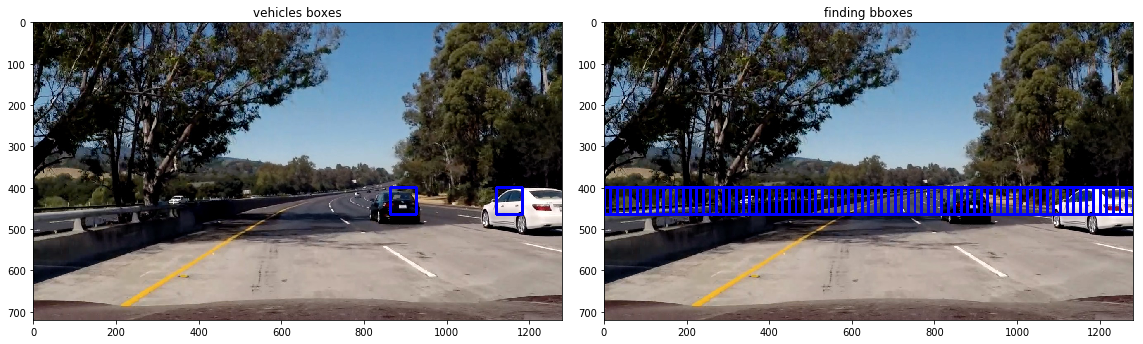

In [9]:
test_image = mpimg.imread('./test_images/test5.jpg')
all_vehicle_bboxes = []

ystart = 400
ystop = 464
scale = 1.0

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
X_scaler = None
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = None
hist_bins = None
hog_channel = 'ALL'
    
bboxes, all_bboxes = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                   cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)

out_img = draw_boxes(test_image, bboxes)
out_all_img = draw_boxes(test_image, all_bboxes)
all_vehicle_bboxes.append(bboxes)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()

axs[0].imshow(out_img)
axs[0].set_title('vehicles boxes')
axs[1].imshow(out_all_img)
axs[1].set_title('finding bboxes')

In [10]:
print('Number of vehicle boxes found', len(bboxes))
print(bboxes)

Number of vehicle boxes found 2
[((864, 400), (928, 464)), ((1120, 400), (1184, 464))]


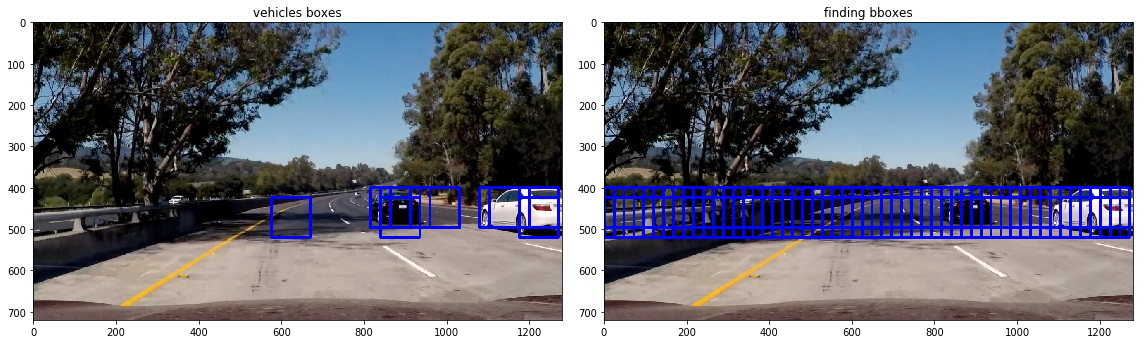

In [11]:
ystart = 400
ystop = 528
scale = 1.5

bboxes, all_bboxes = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                   cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)

out_img = draw_boxes(test_image, bboxes)
out_all_img = draw_boxes(test_image, all_bboxes)
all_vehicle_bboxes.append(bboxes)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()

axs[0].imshow(out_img)
axs[0].set_title('vehicles boxes')
axs[1].imshow(out_all_img)
axs[1].set_title('finding bboxes')

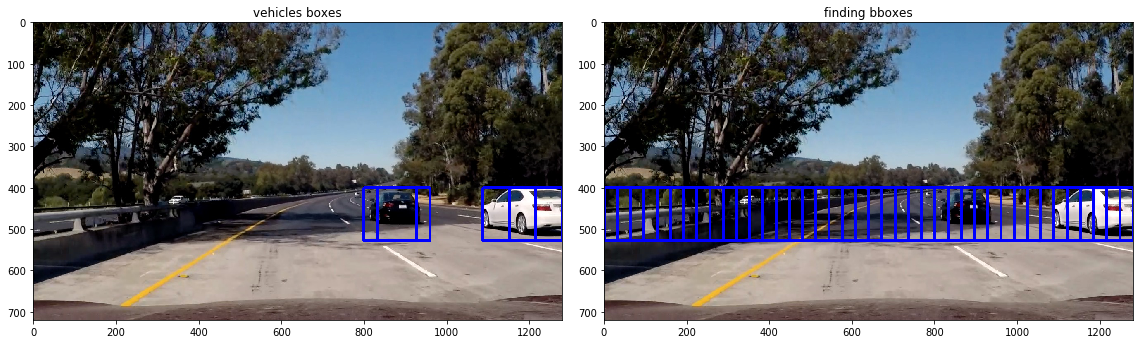

In [12]:
ystart = 400
ystop = 528
scale = 2.0

bboxes, all_bboxes = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                   cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)

out_img = draw_boxes(test_image, bboxes)
out_all_img = draw_boxes(test_image, all_bboxes)
all_vehicle_bboxes.append(bboxes)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()

axs[0].imshow(out_img)
axs[0].set_title('vehicles boxes')
axs[1].imshow(out_all_img)
axs[1].set_title('finding bboxes')

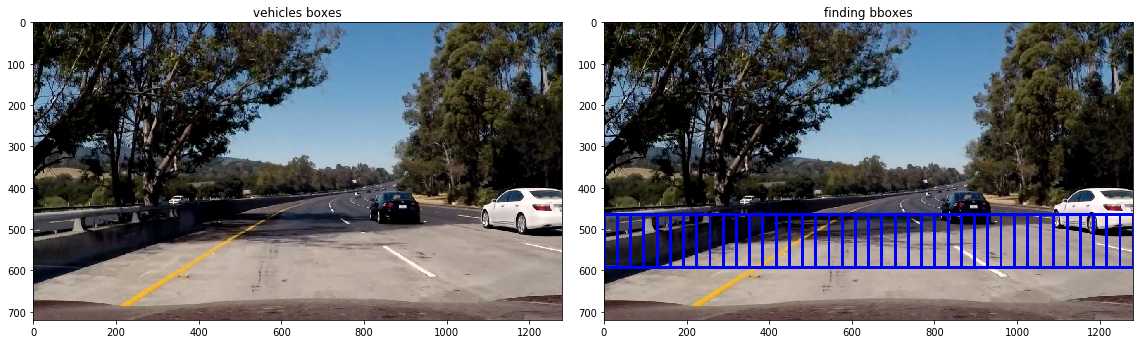

In [13]:
ystart = 464
ystop = 592
scale = 2.0

bboxes, all_bboxes = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                   cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)

out_img = draw_boxes(test_image, bboxes)
out_all_img = draw_boxes(test_image, all_bboxes)
all_vehicle_bboxes.append(bboxes)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()

axs[0].imshow(out_img)
axs[0].set_title('vehicles boxes')
axs[1].imshow(out_all_img)
axs[1].set_title('finding bboxes')

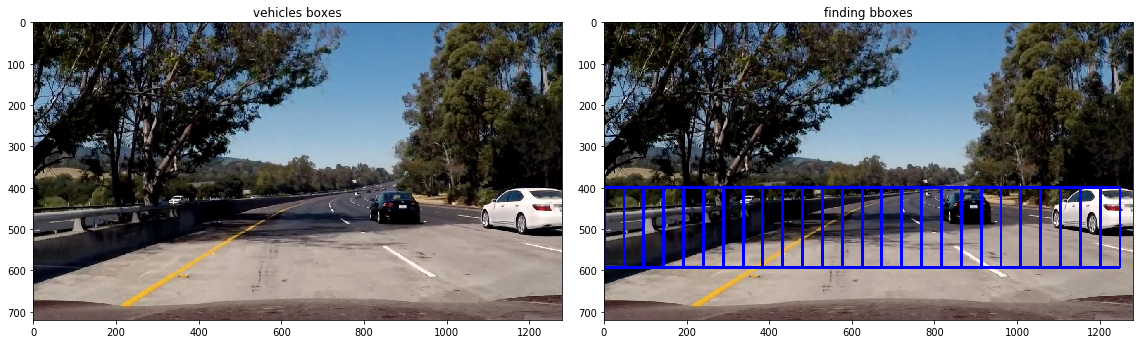

In [14]:
ystart = 400
ystop = 592
scale = 3.0

bboxes, all_bboxes = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                   cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)

out_img = draw_boxes(test_image, bboxes)
out_all_img = draw_boxes(test_image, all_bboxes)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()
all_vehicle_bboxes.append(bboxes)

axs[0].imshow(out_img)
axs[0].set_title('vehicles boxes')
axs[1].imshow(out_all_img)
axs[1].set_title('finding bboxes')

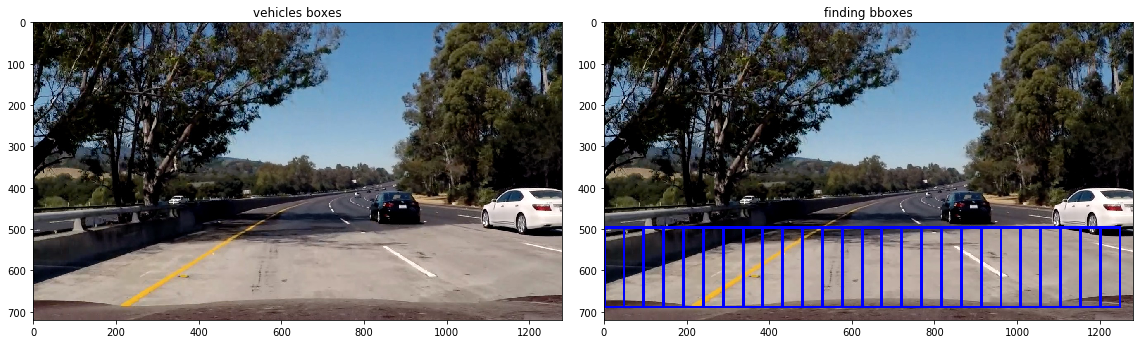

In [15]:
ystart = 496
ystop = 688
scale = 3.0

bboxes, all_bboxes = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                   cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)

out_img = draw_boxes(test_image, bboxes)
out_all_img = draw_boxes(test_image, all_bboxes)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()
all_vehicle_bboxes.append(bboxes)

axs[0].imshow(out_img)
axs[0].set_title('vehicles boxes')
axs[1].imshow(out_all_img)
axs[1].set_title('finding bboxes')

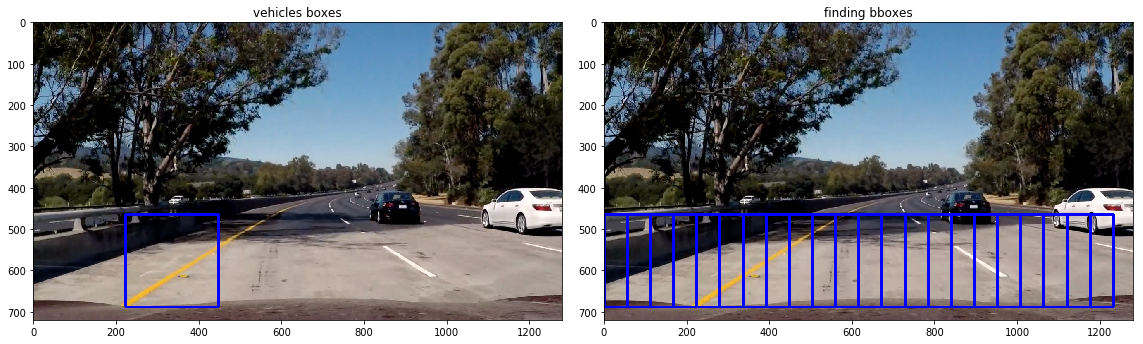

In [16]:
ystart = 464
ystop = 720
scale = 3.5

bboxes, all_bboxes = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                   cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)

out_img = draw_boxes(test_image, bboxes)
out_all_img = draw_boxes(test_image, all_bboxes)
all_vehicle_bboxes.append(bboxes)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()

axs[0].imshow(out_img)
axs[0].set_title('vehicles boxes')
axs[1].imshow(out_all_img)
axs[1].set_title('finding bboxes')

In [17]:
print('Number of vehicle boxes found', len(all_vehicle_bboxes))
for i in range(len(all_vehicle_bboxes)):
    print(len(all_vehicle_bboxes[i]))

Number of vehicle boxes found 7
2
10
4
0
0
0
1


In [18]:
# http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
bboxes = [item for sublist in all_vehicle_bboxes for item in sublist] 
print('Number of vehicle boxes found', len(bboxes))

Number of vehicle boxes found 17


In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

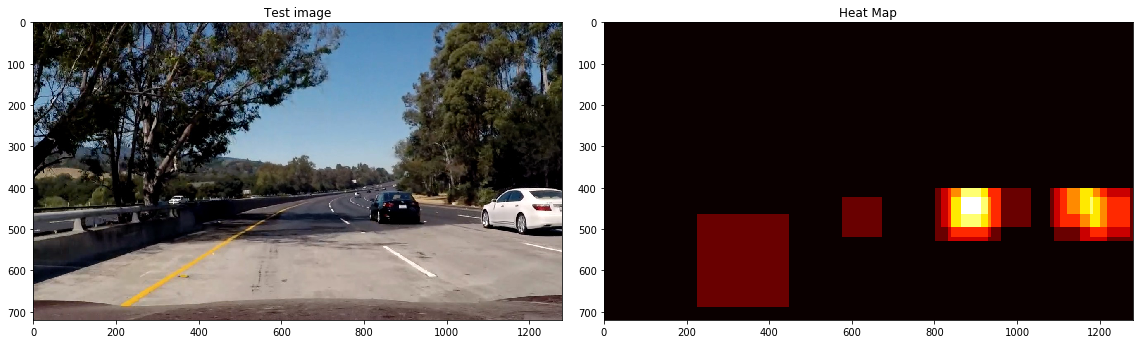

In [20]:
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, bboxes)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()

axs[0].imshow(test_image)
axs[0].set_title('Test image')
axs[1].imshow(heatmap, cmap='hot')
axs[1].set_title('Heat Map')

In [21]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

2 cars found


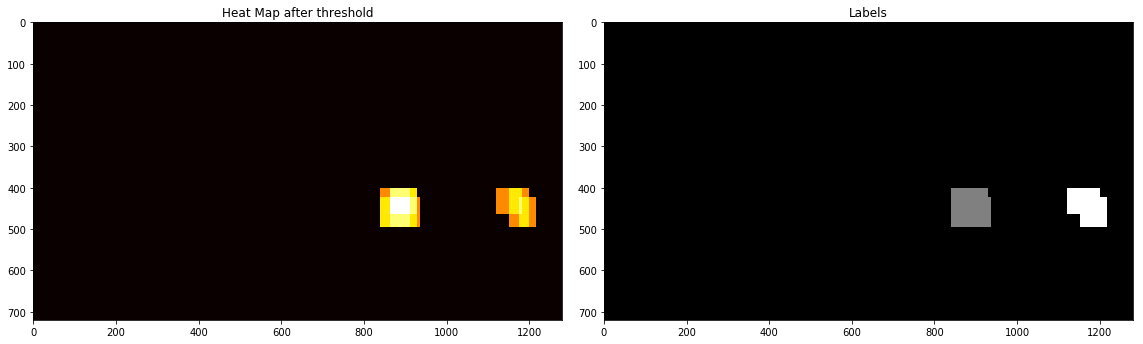

In [22]:
heatmap = apply_threshold(heatmap, 3)

from scipy.ndimage.measurements import label
labels = label(heatmap)
print(labels[1], 'cars found')

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.tight_layout()

axs[0].imshow(heatmap, cmap='hot')
axs[0].set_title('Heat Map after threshold')
axs[1].imshow(labels[0], cmap='gray')
axs[1].set_title('Labels')

In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

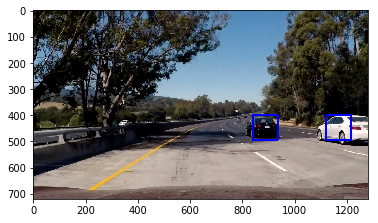

In [24]:
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.imshow(draw_img)

In [25]:
def pipeline(img):
    
    all_vehicle_bboxes = []
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    X_scaler = None
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = None
    hist_bins = None
    hog_channel = 'ALL'
    threshold_value = 3
    delta = 0
    
    ystart = 400 + delta
    ystop = 464 + delta
    scale = 1.0
    
    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)
    
    ystart = 400 + delta
    ystop = 528 + delta
    scale = 1.5
    
    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)
    
    ystart = 400 + delta
    ystop = 528 + delta
    scale = 2.0
    
    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)
    
    ystart = 464 + delta
    ystop = 592 + delta
    scale = 2.0
    
    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)

    ystart = 400 + delta
    ystop = 592 + delta
    scale = 3.0

    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)
    
    ystart = 496
    ystop = 688
    scale = 3.0

    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)

    ystart = 464
    ystop = 720
    scale = 3.5

    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)

    bboxes = [item for sublist in all_vehicle_bboxes for item in sublist] 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heatmap, threshold_value)
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

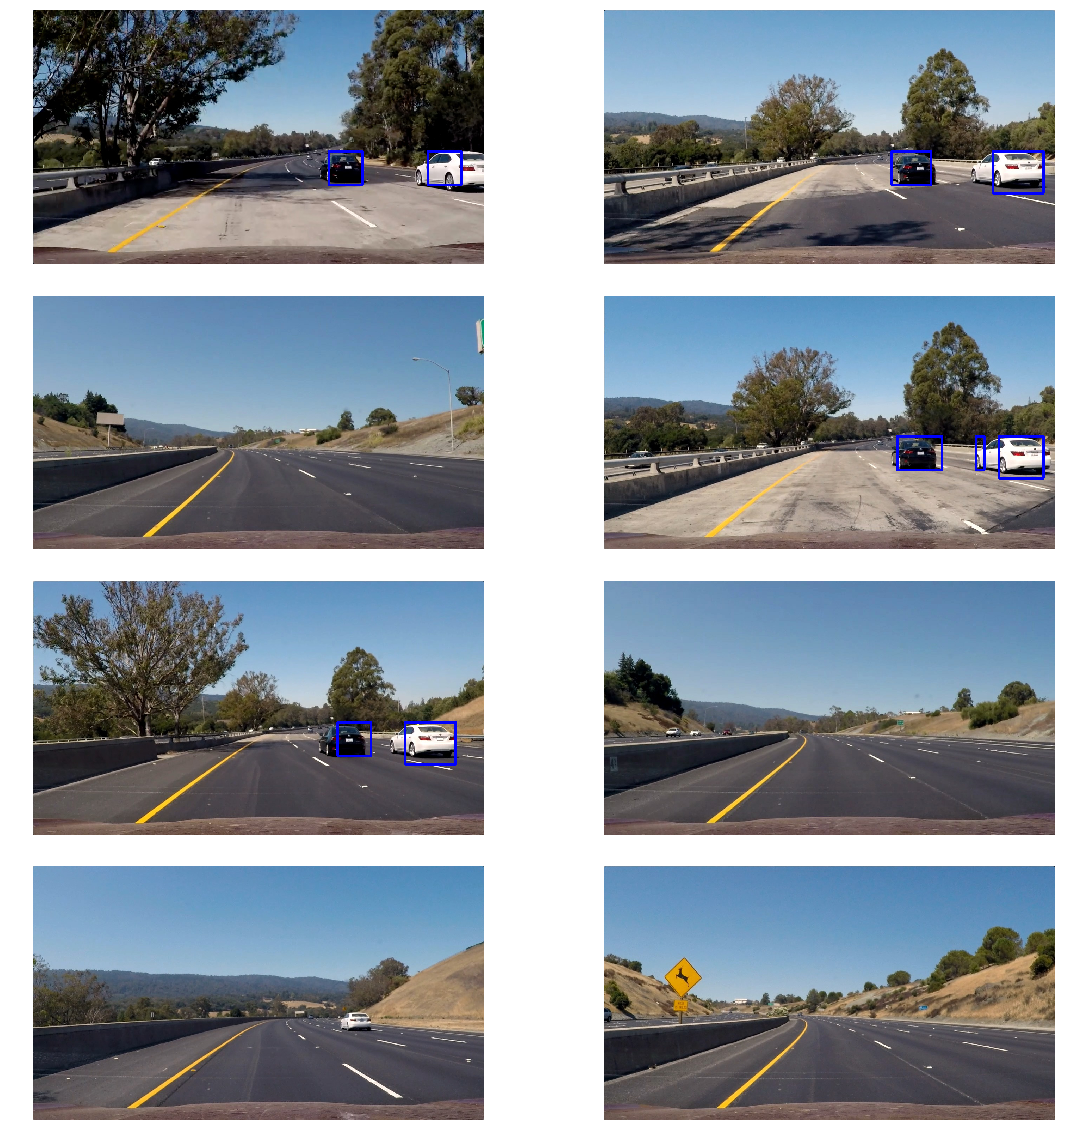

In [26]:
test_images = glob.glob('./test_images/test*.jpg')

# Show example data

fig, axs = plt.subplots(4, 2, figsize=(16, 16))
plt.tight_layout()

row = 0
col = 0
for i in range (len(test_images)):
    test_image = mpimg.imread(test_images[i])
    result_image = pipeline(test_image)
    axs[row,col].imshow(result_image)
    axs[row,col].axis('off')
    row = row + 1
    col = col + 1
    if col > 1:
        col = 0
    if row > 3:
        row = 0
        col = 1
    


### Video Implementation

In [27]:
class Boxes():
    def __init__(self):
        # boxes from 16 pevious frames
        self.bboxes = []
        
    def update(self, new_bboxes):
        self.bboxes.append(new_bboxes)
        if len(self.bboxes) > 16:
            # throw out oldest rectangle set(s)
            self.bboxes = self.bboxes[1:]

    

In [28]:
def video_pipeline(img):
    
    all_vehicle_bboxes = []
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    X_scaler = None
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = None
    hist_bins = None
    hog_channel = 'ALL'
    threshold_value = 3
    
    ystart = 400
    ystop = 464
    scale = 1.0
    
    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)
    
    ystart = 400
    ystop = 528
    scale = 1.5
    
    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)
    
    ystart = 400
    ystop = 528
    scale = 2.0
    
    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)
    
    ystart = 464
    ystop = 592
    scale = 2.0
    
    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)

    ystart = 400
    ystop = 592
    scale = 3.0

    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)
    
    ystart = 496
    ystop = 688
    scale = 3.0

    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)

    ystart = 464
    ystop = 720
    scale = 3.5

    bboxes, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins, hog_channel, colorspace)
    all_vehicle_bboxes.append(bboxes)

    bboxes = [item for sublist in all_vehicle_bboxes for item in sublist]
    if len(bboxes) > 0:
        video_boxes.update(bboxes)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    for current_bboxes in video_boxes.bboxes:
        heat = add_heat(heat, current_bboxes)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    threshold_value = threshold_value + len(video_boxes.bboxes)//2
    heatmap = apply_threshold(heatmap, threshold_value)
    
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [29]:
video_boxes = Boxes()

video_output = 'test_video_out.mp4'
input_clip = VideoFileClip('test_video.mp4')
result_clip = input_clip.fl_image(video_pipeline)
%time result_clip.write_videofile(video_output, audio=False)

print('Video created')

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 25.5 s, sys: 212 ms, total: 25.7 s
Wall time: 21.2 s
Video created


In [30]:
video_boxes = Boxes()

video_output = 'project_video_out.mp4'
input_clip = VideoFileClip('project_video.mp4')
result_clip = input_clip.fl_image(video_pipeline)
%time result_clip.write_videofile(video_output, audio=False)

print('Video created')

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [10:34<00:00,  2.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 13min 37s, sys: 4.4 s, total: 13min 41s
Wall time: 10min 35s
Video created
